<a href="https://colab.research.google.com/github/lauragabrysiak/mitx_applied_data_science/blob/main/CAPSTONE_music_recsys_gabrysiak_202312.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System**

## **System Configuration**

#### Mount Drive

In [66]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


#### Install Libraries

In [67]:
# Installing surprise library
!pip install surprise

#### Import Libraries

In [68]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
from collections import defaultdict             # A dictionary output that does not raise a key error

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # data visualization
import seaborn as sns                           # data visualization advanced

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

In [69]:
# To compute the accuracy of models
from surprise import accuracy
# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset
# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split
# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing K-Fold cross-validation
from surprise.model_selection import KFold
# For implementing clustering-based recommendation system
from surprise import CoClustering
## Added classes
# from surprise import Similarity

### **Datasets**

#### Import datasets

In [70]:
# Importing the datasets

# Original final df
#df_final = pd.read_csv('/content/sample_data/df_final.csv'
#                  , on_bad_lines='skip')                        # some of the lines had formatting issues. This can be solved with bad_lines = skip
# Spotipy augmented final df
df_final = pd.read_csv('/content/sample_data/spotipy_concat_final_n_1000.csv'
                  , on_bad_lines='skip')

In [71]:
rows, columns = df_final.shape
print("Song Dataset: No of rows =", rows, "and No of columns =", columns)

Song Dataset: No of rows = 916 and No of columns = 20


In [72]:
print(df_final.info())   # there is some missing information (title (-15) /release (-5) )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   user_id                  916 non-null    int64 
 1   song_id                  916 non-null    int64 
 2   play_count               916 non-null    int64 
 3   song_title               916 non-null    object
 4   song_release             916 non-null    object
 5   song_artist              916 non-null    object
 6   song_year                916 non-null    int64 
 7   title                    916 non-null    object
 8   popularity               916 non-null    int64 
 9   is_local                 916 non-null    bool  
 10  explicit                 916 non-null    bool  
 11  duration_ms              916 non-null    int64 
 12  album                    916 non-null    object
 13  release_date             916 non-null    object
 14  album_type               916 non-null    o

In [73]:
## Merge all metadata into metadata_info column:
def merge_columns(row):
    return {
        'play_count': row['play_count'],
        'song_title': row['song_title'],
        'song_release': row['song_release'],
        'song_artist': row['song_artist'],
        'song_year': row['song_year'],
        'title': row['title'],
        'popularity': row['popularity'],
        'is_local': row['is_local'],
        'explicit': row['explicit'],
        'duration_ms': row['duration_ms'],
        'album': row['album'],
        'release_date': row['release_date'],
        'album_type': row['album_type'],
        'album_available_markets': row['album_available_markets'],
        'artist': row['artist'],
        'artist_popularity': row['artist_popularity'],
        'artist_followers': row['artist_followers'],
        'artist_genres': row['artist_genres']
    }

# Apply the function to create the new metadata_info column
df_final['metadata_info'] = df_final.apply(merge_columns, axis=1)

# Display the DataFrame
print(df_final.head(3))

   user_id  song_id  play_count                       song_title  \
0     6958      447           1               Daisy And Prudence   
1     6958      512           1  The Ballad of Michael Valentine   
2     6958      703           1            They Might Follow You   

   song_release   song_artist  song_year  \
0  Distillation  Erin McKeown       2000   
1       Sawdust   The Killers       2004   
2   Tiny Vipers   Tiny Vipers       2007   

                                             title  popularity  is_local  ...  \
0                               Daisy And Prudence           7     False  ...   
1                  The Ballad Of Michael Valentine          35     False  ...   
2  They Might Be Following You with Unmarked Teeth           0     False  ...   

   duration_ms                   album release_date   album_type  \
0       293400            Distillation   2000-10-10        album   
1       230346                 Sawdust   2007-01-01  compilation   
2       217548  Blood

## **Exploratory Data Analysis**

### **Numerical Variables EDA**

In [74]:
# numerical variables
print(df_final.describe(exclude='object').transpose())

                   count unique    top freq             mean            std  \
user_id            916.0    NaN    NaN  NaN      46666.89738   18122.687247   
song_id            916.0    NaN    NaN  NaN      4892.412664    2955.760471   
play_count         916.0    NaN    NaN  NaN         1.733624       1.046986   
song_year          916.0    NaN    NaN  NaN      1772.751092     641.669471   
popularity         916.0    NaN    NaN  NaN        56.962882      26.530006   
is_local             916      1  False  916              NaN            NaN   
explicit             916      2  False  820              NaN            NaN   
duration_ms        916.0    NaN    NaN  NaN    237610.336245   76711.903287   
artist_popularity  916.0    NaN    NaN  NaN        64.712882      20.376926   
artist_followers   916.0    NaN    NaN  NaN  11456416.527293  20589786.4476   

                       min       25%        50%        75%          max  
user_id             5480.0   39814.0    49549.0    57932

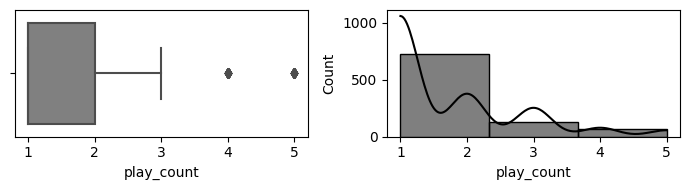

In [75]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
# p1: top users by ratings
#sns.barplot(x='song_id', y='play_count', data=df_final, color='black', ax=axes[0])
sns.boxplot(x = df_final["play_count"], color = 'grey', ax=axes[0])
# p2: ratings distribution (min = 5 given selection criteria)
sns.histplot(df_final['play_count'], bins=3, kde=True, color='black', ax=axes[1])
fig.tight_layout()

### **Categorical Variables EDA**

In [76]:
# categorical variables
print(df_final.describe(include='object').transpose())

                        count unique  \
song_title                916    365   
song_release              916    288   
song_artist               916    165   
title                     916    360   
album                     916    308   
release_date              916    267   
album_type                916      3   
album_available_markets   916     60   
artist                    916    256   
artist_genres             916    220   
metadata_info             916    639   

                                                                       top  \
song_title                                                    Use Somebody   
song_release                              Ray Guns Are Not Just The Future   
song_artist                                                       Coldplay   
title                                         Somebody That I Used To Know   
album                                               Lungs (Deluxe Edition)   
release_date                                       

In [77]:
# Multivariate categorical analysis: Top songs with year information
df_final.groupby(['song_id','song_title','song_year','artist_popularity'])['play_count'].agg(['mean', 'count', 'max']).sort_values(by='count', ascending=False).reset_index().round().head(10)

,song_id,song_title,song_year,artist_popularity,mean,count,max
0,8582,Use Somebody,2008,65,2.0,14,4
1,6293,Yellow,2000,86,2.0,10,4
2,703,They Might Follow You,2007,0,2.0,10,3
3,4270,Don't Stop The Music,2007,47,1.0,9,1
4,1118,Clocks,2002,87,2.0,8,4
5,1286,Somebody To Love,2010,82,3.0,8,5
6,1480,Fast As I Can,2000,42,1.0,7,1
7,7796,Love Story,2008,100,1.0,6,2
8,4676,The Trouble With Love Is,2003,78,1.0,6,1
9,8107,You Only Live Once,2005,73,1.0,6,1


Songs played in a year

In [78]:
# Find out the number of songs played in a year
  # Hint: Use groupby function on the 'year' column
top_songs_year = df_final.groupby(['song_year'])['play_count'].agg(['mean', 'count','max']).sort_values(['song_year'],ascending=False).reset_index()
round(top_songs_year).head(10)

,song_year,mean,count,max
0,2010,2.0,35,5
1,2009,2.0,139,5
2,2008,2.0,127,4
3,2007,2.0,123,5
4,2006,2.0,71,5
5,2005,2.0,57,5
6,2004,2.0,13,3
7,2003,2.0,65,5
8,2002,2.0,38,5
9,2001,2.0,22,5


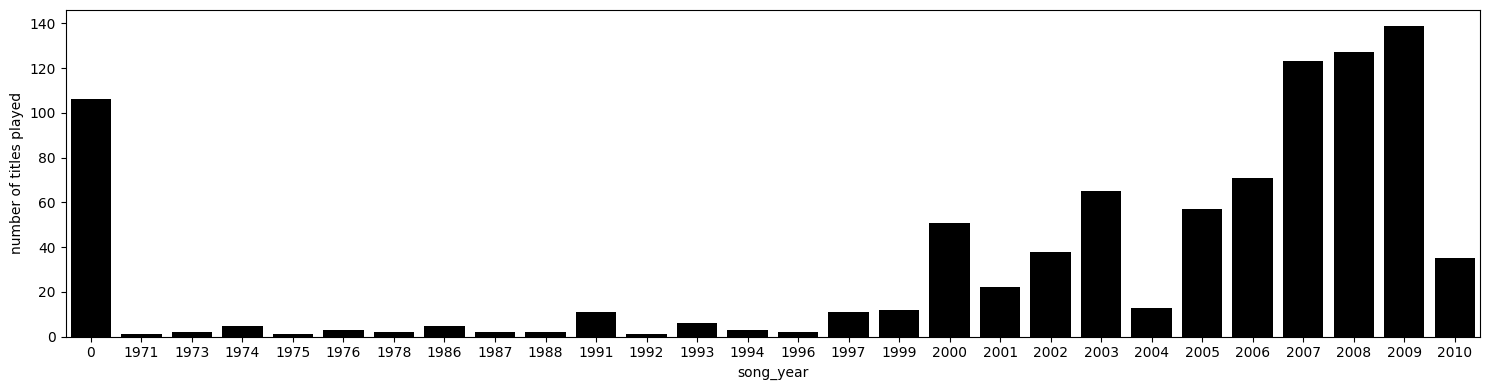

In [79]:
# Create a barplot plot with y label as "number of titles played" and x -axis year

# Set the figure size
fig = plt.figure(figsize= (15,4))
sns.barplot(x='song_year', y='count', data=top_songs_year, color='black')
# Set the x label of the plot
plt.xlabel("song_year")
# Set the y label of the plot
plt.ylabel('number of titles played')
# Show the plot
fig.tight_layout()

## Building various models

### **M1) Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [80]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column
avg_counts= df_final.groupby('song_id')['play_count'].mean().reset_index()

# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column
count_counts = df_final.groupby('song_id')['play_count'].count().reset_index()

In [81]:
# Making a dataframe with the average_count and play_freq
avg_play_counts = df_final.groupby(['song_id','song_title'])['play_count'].agg(['mean', 'count']).sort_values(by='count', ascending=False).reset_index()

# Let us see the first five records of the final_play dataset
avg_play_counts.head()

,song_id,song_title,mean,count
0,8582,Use Somebody,2.142857,14
1,6293,Yellow,2.400000,10
2,703,They Might Follow You,1.500000,10
3,4270,Don't Stop The Music,1.000000,9
4,1118,Clocks,1.875000,8


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [82]:
# Build the function to find top n songs

# p1: avg_play_counts: dataframe to sort
# p2: n: n products
# p3: min_playcounts: def what a min interaction is (min())

def top_n_songs(df, n, min_playcount_def):

    # Finding songs with minimum number of playcounts
    #min_playcount_def = df['count'].min()                                     # def a min playcount
    min_recommendations = df[df['count'] >=  min_playcount_def]               # recommendations that comprise def of min playcounts had to be fixed to be >= as they are min requirements

    # Sorting values with respect to average rating
    sorted_recommendations = min_recommendations.sort_values(['count'], ascending = False)#.reset_index()

    return sorted_recommendations[:n]

In [83]:
# Testing function
result = top_n_songs(avg_play_counts, 3, 5)
test = avg_play_counts[avg_play_counts['count'] >=  5].sort_values(['count'], ascending = False)

print(
      avg_play_counts.head(3)
      , "\n\n"
      , result # getting the index
      , "\n\n"
      , test[:3]
      )

   song_id             song_title      mean  count
0     8582           Use Somebody  2.142857     14
1     6293                 Yellow  2.400000     10
2      703  They Might Follow You  1.500000     10 

    song_id             song_title      mean  count
0     8582           Use Somebody  2.142857     14
2      703  They Might Follow You  1.500000     10
1     6293                 Yellow  2.400000     10 

    song_id             song_title      mean  count
0     8582           Use Somebody  2.142857     14
2      703  They Might Follow You  1.500000     10
1     6293                 Yellow  2.400000     10


In [84]:
# Recommend top 10 songs using the function defined above
top_n_songs(avg_play_counts, 10, 5)

,song_id,song_title,mean,count
0,8582,Use Somebody,2.142857,14
2,703,They Might Follow You,1.500000,10
1,6293,Yellow,2.400000,10
3,4270,Don't Stop The Music,1.000000,9
4,1118,Clocks,1.875000,8
5,1286,Somebody To Love,3.250000,8
6,1480,Fast As I Can,1.000000,7
10,8247,Tighten Up,2.333333,6
13,9678,Cheryl Tweedy,1.333333,6
11,8481,Party In The U.S.A.,1.166667,6


### **User User Similarity-Based Collaborative Filtering**

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example playcounts.

### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [85]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?

### Useful function from surprise library

In [86]:
# To compute the accuracy of models
from surprise import accuracy
# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset
# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split
# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing K-Fold cross-validation
from surprise.model_selection import KFold
# For implementing clustering-based recommendation system
from surprise import CoClustering

In [172]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5)) # min = 0 and max = 5 x played by user

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)      # can be solved with S1 count_df

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)
trainset.metadata = df_final['metadata_info'].tolist()

In [231]:
# test splitting:
print(reader, "\n"
      , data, "\n"
      , trainset, "\n"
      #, trainset.metadata, "\n"
      , testset[:2]
      )

 [(22749, 8092, 1.0), (57932, 2403, 2.0)]


**Think About It:** How changing the test size would change the results and outputs?

### M2) Defining User - User Similarity Model

1. Initialize the model with similarity option
1. Fit the model on the training data
1. Use the precision_recall_at_k function to calculate the metrics on the test data
1. Provide your observations on the output (Test on dataset: observed song / unobserved song)
1. Hyperparameter Tuning with GridSearch
1. Fit the model on the training data
1. Use the precision_recall_at_k function to calculate the metrics on the test data
1. recommendations function
1. ranked recommendation

#### Embedding Metadata into the modelling process:

In [ ]:
#from surprise import Similarity
#
#class CustomUserSimilarity(Similarity):
#    def compute_sim(self, user):
#        # Access user metadata using self.trainset.metadata
#        # Implement your custom similarity logic
#        pass

In [90]:
# Build the default user-user-similarity model

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
# Use random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options
                         , verbose=False
                         , random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model
precision_recall_at_k(sim_user_user)

RMSE: 1.2032
Precision:  0.38
Recall:  0.626
F_1 score:  0.473


**Observations and Insights:**
Baseline model is reasanoble but performance metrics can be improved.

In [91]:
# Predicting play_count for a sample user with a listened song

# Use any user id and song_id
rand_index = np.random.randint(1, len(df_final))

# Predicting rating for a sample user with an interacted product
sim_user_user.predict(df_final['user_id'].iloc[rand_index]
                      , df_final['song_id'].iloc[rand_index]
                      , r_ui = 5
                      , verbose = True)

user: 6958       item: 719        r_ui = 5.00   est = 1.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=6958, iid=719, r_ui=5, est=1.0, details={'actual_k': 1, 'was_impossible': False})

In [92]:
# Predicting play_count for a sample user with a song not-listened by the user

 #predict play_count for any sample user

# using a function from the elective project:
def n_users_not_interacted_with(n, data, song_id):
    users_interacted_with_product = set(data[data['song_id'] == song_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [93]:
# List of 5 users that have not interacted with the song
n_users_not_interacted_with(
                          5
                          , df_final
                          , 5725
                          )

[56576, 35457, 52928, 39814, 40583]

In [94]:
# Predicting play_count for a sample user with a song not-listened by the user

sim_user_user.predict( 56576
                      , 5725
                      , r_ui = 5
                      , verbose = True)

user: 56576      item: 5725       r_ui = 5.00   est = 2.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid=56576, iid=5725, r_ui=5, est=2.0, details={'actual_k': 2, 'was_impossible': False})

**Observations and Insights:**

Legend:

- uid: This stands for "user id" and represents the unique identifier of the user for whom the prediction was made. In this case, the user ID is 'dc9fcf22d3b8d1bf718876dea5964149c58eb7c8'.

- iid: This stands for "item id" and represents the unique identifier of the item (in this context, a song) for which the prediction was made. In this case, the item ID is 'SOMYXWV12A8C14232E'.

- r_ui: This represents the "real" or actual rating given by the user for the item. In this case, the actual rating is 5.

- est: This represents the estimated or predicted rating for the user-item pair. In this case, the predicted rating is approximately 1.53.

- details: This is a dictionary containing additional details about the prediction. In this specific case, the details include the number of actual neighbors considered for the prediction (actual_k: 40) and whether the prediction was made without any issues (was_impossible: False).


**Prediction:**

User 'dc9fcf22d3b8d1bf718876dea5964149c58eb7c8' is predicted to play the song 'SOMYXWV12A8C14232E' approximately 1.53. The actual playcount given by the user is 5. The prediction is based on collaborative filtering, and 40 nearest neighbors were considered in the process. No issues were encountered during the prediction process (was_impossible: False).

**Hyperparameter Tuning**

Now, let's try to tune the model and see if we can improve the model performance.

In [95]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k':[40],                       # number of neighbors to consider (40 default also equal to the ones in round 1)
        'min_k': [1],                   # minimum number of neighbors to take into account for aggregation
        'sim_options': {
        'name': ['cosine'
                , 'pearson'
                , 'msd']                # similarity metric (cosine or pearson). Consider all options
}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(  KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
# Use entire data for GridSearch
gs.fit(data)

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.083002115635411 


Combination of parameters for best RMSE score {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}} 



In [116]:
# Train the best model found in above gridsearch (updated values)
sim_options = {'name': 'msd'
              , 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values as the optimized model
sim_user_user_optimized = KNNBasic(sim_options=sim_options
                                   , k = gs.best_params['rmse']['k']
                                   , min_k=1
                                   , random_state=1
                                   , verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)     # we use optimized model this time
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.1684
Precision:  0.384
Recall:  0.581
F_1 score:  0.462


In [97]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
rand_index = np.random.randint(1, len(df_final))

# Predicting rating for a sample user with an interacted product
sim_user_user_optimized.predict(df_final['user_id'].iloc[rand_index]
                      , df_final['song_id'].iloc[rand_index]
                      , r_ui = 2
                      , verbose = True)

user: 57932      item: 5607       r_ui = 2.00   est = 1.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=57932, iid=5607, r_ui=2, est=1.0, details={'actual_k': 1, 'was_impossible': False})

In [117]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
sim_user_user_optimized.predict(
                      6958
                      , 4058
                      , r_ui = 3
                      , verbose = True)

user: 6958       item: 4058       r_ui = 3.00   est = 1.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=6958, iid=4058, r_ui=3, est=1.0, details={'actual_k': 1, 'was_impossible': False})

**Observations and Insights:**

The model considerable improved after hyperparameter tuning:
```
RMSE: -0.0795, F_1: 0.011, Precision: 0.051, Recall: -0.073
```


Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [123]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating a user-item interactions matrix
    user_item_interactions_matrix = data.pivot_table(
        index='user_id',
        columns='song_id',
        values='play_count'
    )

    # Extracting those song ids which the user_id has not listened yet
    non_interacted_songs = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the song ids which user_id has not interacted yet
    for song_id in non_interacted_songs:

        est = algo.predict(user_id, song_id).est

        # [Deprecated] Predicting the playcounts
        #est = algo.predict(user_id, song_id).est
        # Appending the predicted playcounts
        #recommendations.append((song_id, est))

        # Extracting song title for the recommended item_id
        song_title = data[data['song_id'] == song_id]['song_title'].iloc[0]
        # Appending the predicted play count along with song title
        recommendations.append({'song_id': song_id, 'song_title': song_title, 'predicted_play_count': est})

    # Sorting the predicted ratings in descending order
    recommendations = sorted(recommendations, key=lambda x: x['predicted_play_count'], reverse=True)

    return recommendations[:top_n]

In [119]:
# testing user_item_interactions_matrix
df_final.pivot_table(
                                                index = 'user_id'
                                              , columns = 'song_id' #metadata_info'
                                              , values = 'play_count').sample(3)

song_id,21,22,52,97,114,145,154,194,198,208,...,9678,9712,9724,9771,9847,9925,9931,9939,9960,9981
user_id,,,,,,,,,,,,,,,,,,,,,
67308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
70318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
54439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### M2 Final Recommendations (6958)

In [212]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine

# randomized user_id
# rand_index = np.random.randint(1, len(df_final))
# testing randomized user_id
# print(df_final['user_id'].iloc[rand_index])

# get_recommendation function with ypdated values:
recommendations = get_recommendations( df_final
                                      , 6958 #df_final['user_id'].iloc[rand_index]    # random user
                                      , 5
                                      #, sim_user_user
                                      , sim_user_user_optimized # adding the optimized model
                                      )
recommendations

[{'song_id': 2048, 'song_title': 'Already Gone', 'predicted_play_count': 5},
 {'song_id': 2098, 'song_title': 'Down To Earth', 'predicted_play_count': 5},
 {'song_id': 2734, 'song_title': 'Love Me', 'predicted_play_count': 5},
 {'song_id': 4645,
  'song_title': 'Live And Let Die',
  'predicted_play_count': 5},
 {'song_id': 1994,
  'song_title': 'Nothing Better (Album)',
  'predicted_play_count': 4.085714285714286}]

In [213]:
# Building the dataframe for above recommendations with columns "song_id" and "play_freq"
df_output = pd.DataFrame(recommendations)
df_output = df_output.rename(columns={'song_id': 'prod_id'
, 'song_title': 'title'
, 'predicted_play_count': 'play_freq'})
df_output

,prod_id,title,play_freq
0,2048,Already Gone,5.000000
1,2098,Down To Earth,5.000000
2,2734,Love Me,5.000000
3,4645,Live And Let Die,5.000000
4,1994,Nothing Better (Album),4.085714


### Correcting the play_counts and Ranking the above songs

In [133]:
def ranking_songs(recommendations, final_rating):

    # Sort the songs based on play counts
    ranked_songs = final_rating.loc[[item[0] for item in recommendations]].sort_values('play_freq', ascending=False)[['play_freq']].reset_index()

    # Merge with the recommended songs to get predicted play_count
    ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['prod_id', 'play_freq']), on='prod_id', how='inner')

    # Rank the songs based on corrected play_counts
    ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])

    # Sort the songs based on corrected play_counts
    ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending=False)

    return ranked_songs

### M3) Item Item Similarity-based collaborative filtering recommendation systems

In [135]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options
                         , random_state = 1
                         , verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9300
Precision:  0.325
Recall:  0.588
F_1 score:  0.419


In [136]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user
sim_item_item.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.40   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.3978497683691953, details={'actual_k': 20, 'was_impossible': False})

In [137]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
user = n_users_not_interacted_with(1, df_final, 1671)

sim_item_item.predict(user[0]
                      , 1671
                      , verbose = True)

user: 56576      item: 1671       r_ui = None   est = 2.08   {'actual_k': 13, 'was_impossible': False}


Prediction(uid=56576, iid=1671, r_ui=None, est=2.08119101207053, details={'actual_k': 13, 'was_impossible': False})

In [138]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k': [10, 20, 30]                      # number of neighbors to consider
        , 'min_k': [3, 6, 9]                   # minimum number of neighbors to take into account for aggregation
        , 'sim_options': {
        'name': ['cosine'
                , 'msd']  # similarity metric (cosine or msd)
                }
        , 'user_based': [False]
        }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV( KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
gs.fit(data)

# Check data
#print("data check:", data.head(5), "\n\n")

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.0367587232303441 


Combination of parameters for best RMSE score {'k': 10, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}, 'user_based': False} 



**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [139]:
# Apply the best modle found in the grid search
# Declaring the similarity options
sim_options = {'name': 'msd',
               'user_based': True}

# KNN optimized algorithm is used to find desired similar items
sim_item_item_optimized = KNNBasic(sim_options=sim_options
                                   , k=gs.best_params['rmse']['k']
                                   , min_k=9
                                   , random_state=1
                                   , verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9491
Precision:  0.332
Recall:  0.846
F_1 score:  0.477


In [140]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.75   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.7486338797814207, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [141]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user
sim_item_item_optimized.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.75   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.7486338797814207, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [142]:
# Find five most similar items to the item with inner id 0
internal_id = 0
sim_item_item_optimized.get_neighbors(internal_id
                                      , k=5
                                      #, sim_options={'name': 'msd'}
                                      )

[4, 12, 7, 10, 20]

#### M3 Final Recommendations (6958)

In [210]:
# Making top 5 recommendations for any user_id  with item_item_similarity-based recommendation engine
recommendations = get_recommendations( df_final
                                      , 6958 #df_final['user_id'].iloc[rand_index]
                                      , 5
                                      , sim_item_item_optimized
                                      )
recommendations

[{'song_id': 21,
  'song_title': 'Back Against The Wall',
  'predicted_play_count': 1.7486338797814207},
 {'song_id': 22,
  'song_title': 'Halo',
  'predicted_play_count': 1.7486338797814207},
 {'song_id': 52,
  'song_title': 'Halo',
  'predicted_play_count': 1.7486338797814207},
 {'song_id': 97,
  'song_title': 'Harder Better Faster Stronger',
  'predicted_play_count': 1.7486338797814207},
 {'song_id': 114,
  'song_title': "Adam's Song",
  'predicted_play_count': 1.7486338797814207}]

In [211]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
df_output = pd.DataFrame(recommendations)
df_output = df_output.rename(columns={'song_id': 'prod_id'
, 'song_title': 'title'
, 'predicted_play_count': 'play_freq'})
df_output

,prod_id,title,play_freq
0,21,Back Against The Wall,1.748634
1,22,Halo,1.748634
2,52,Halo,1.748634
3,97,Harder Better Faster Stronger,1.748634
4,114,Adam's Song,1.748634


In [ ]:
# Applying the ranking_songs function
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

### M4) Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [149]:
# Build baseline model using svd

# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset) #trainset has no missing values

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8544
Precision:  0.337
Recall:  0.641
F_1 score:  0.442


In [152]:
from surprise.model_selection import cross_validate

svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9914  1.0689  0.9802  0.8848  0.9196  0.9034  1.0589  0.7783  0.8839  0.9419  0.9411  0.0831  
MAE (testset)     0.7801  0.7824  0.7197  0.6922  0.6936  0.6773  0.7821  0.6085  0.6970  0.7278  0.7161  0.0525  
Fit time          0.03    0.02    0.04    0.03    0.03    0.02    0.03    0.02    0.03    0.02    0.03    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [153]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict(6958
            , 1671
            , r_ui = 2
            , verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.64   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.637676247469631, details={'was_impossible': False})

In [154]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
user = n_users_not_interacted_with(1, df_final, 3232)
sim_item_item_optimized.predict(user[0]
                      , 3232
                      , r_ui = 2
                      , verbose = True)

user: 56576      item: 3232       r_ui = 2.00   est = 1.75   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=56576, iid=3232, r_ui=2, est=1.7486338797814207, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [155]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30]
              ,'lr_all': [0.001, 0.005, 0.01]
              ,'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD
                   , param_grid
                   , measures = ['rmse']
                   , cv = 3
                   , n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(" Best RMSE score", gs_svd.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs_svd.best_params['rmse'], "\n")

 Best RMSE score 0.9396246293310441 


Combination of parameters for best RMSE score {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2} 



**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [156]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs=30
                    , lr_all=0.01
                    , reg_all=0.2
                    , random_state=1
                    , verbose=False)

# Train the algorithm on the train set
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8569
Precision:  0.358
Recall:  0.604
F_1 score:  0.45


In [192]:
results = cross_validate(svd_optimized, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.7973  0.8983  0.9707  0.9215  0.9830  0.9283  1.0289  0.8620  0.9495  1.0714  0.9411  0.0753  
MAE (testset)     0.6122  0.6752  0.7300  0.7029  0.7085  0.7495  0.7898  0.6312  0.6904  0.7463  0.7036  0.0516  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [157]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
svd_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.57   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.5704829934837385, details={'was_impossible': False})

In [158]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
user = n_users_not_interacted_with(1, df_final, 3232)
svd_optimized.predict(6958#user[0]
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.33   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3306300291136808, details={'was_impossible': False})

#### M4 Final Recommendations (6958)

In [206]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
recommendations = get_recommendations( df_final
                                      , 6958 #df_final['user_id'].iloc[rand_index]
                                      , 5
                                      , svd_optimized
                                      )
recommendations

[{'song_id': 7210,
  'song_title': 'Fancy Footwork',
  'predicted_play_count': 2.400272313385472},
 {'song_id': 7889,
  'song_title': 'Make Love To Your Mind',
  'predicted_play_count': 2.3851905793918995},
 {'song_id': 4645,
  'song_title': 'Live And Let Die',
  'predicted_play_count': 2.351118636790082},
 {'song_id': 1286,
  'song_title': 'Somebody To Love',
  'predicted_play_count': 2.280398511208697},
 {'song_id': 3548,
  'song_title': 'Easy Love',
  'predicted_play_count': 2.208140083753294}]

In [207]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
df_output = pd.DataFrame(recommendations)
df_output = df_output.rename(columns={'song_id': 'prod_id'
, 'song_title': 'title'
, 'predicted_play_count': 'play_freq'})
df_output

,prod_id,title,play_freq
0,7210,Fancy Footwork,2.400272
1,7889,Make Love To Your Mind,2.385191
2,4645,Live And Let Die,2.351119
3,1286,Somebody To Love,2.280399
4,3548,Easy Love,2.208140


In [ ]:
# Ranking songs based on above recommendations
# Applying the ranking_songs function
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

### Embedding Metadata to SVD

In [202]:
trainset.metadata = df_final['metadata_info'].tolist()

class SVDWithMetadata(SVD):
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, metadata_weight=0.1):
        super().__init__(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
        self.metadata_weight = metadata_weight

    def fit(self, trainset):
        # Call the fit method of the parent class
        super().fit(trainset)
        return self

    def estimate(self, u, i):
        # Use the parent class's estimate method
        baseline = super().estimate(u, i)

        # Extract metadata information & Implement your custom logic to incorporate metadata
        metadata = self.trainset.metadata[u]
        metadata_score = self.calculate_metadata_score(metadata)
        # Combine the baseline score and metadata score
        estimated_score = baseline + self.metadata_weight * metadata_score

        return estimated_score

    def calculate_metadata_score(self, metadata):
        # Implement your custom logic to calculate the metadata score
        # This could involve processing the metadata and producing a score
        return 0  # Replace this with your actual calculation

In [203]:
# Building the optimized SVD model using optimal hyperparameters
svd_metadata = SVDWithMetadata(
                    #  n_epochs=30
                    #, lr_all=0.01
                    #, reg_all=0.2
                    #, random_state=1
                    #, verbose=False
                      )

# Train the algorithm on the train set
svg_metadata.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svg_metadata)

RMSE: 0.8501
Precision:  0.378
Recall:  0.604
F_1 score:  0.465


#### M4 Meta Final Recommendations (6958)

In [204]:
# Getting top 5 recommendations for user_id x using "svg_metadata" algorithm
recommendations = get_recommendations( df_final
                                      , 6958 #df_final['user_id'].iloc[rand_index]
                                      , 5
                                      , svg_metadata
                                      )
recommendations

[{'song_id': 1286,
  'song_title': 'Somebody To Love',
  'predicted_play_count': 2.098782211569386},
 {'song_id': 8247,
  'song_title': 'Tighten Up',
  'predicted_play_count': 1.9790629388576022},
 {'song_id': 7780,
  'song_title': 'Home',
  'predicted_play_count': 1.9755889404556595},
 {'song_id': 4975,
  'song_title': 'Until The End Of Time',
  'predicted_play_count': 1.9496678409049546},
 {'song_id': 4645,
  'song_title': 'Live And Let Die',
  'predicted_play_count': 1.9488981679347919}]

In [205]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
df_output = pd.DataFrame(recommendations)
df_output = df_output.rename(columns={'song_id': 'prod_id'
, 'song_title': 'title'
, 'predicted_play_count': 'play_freq'})
df_output

,prod_id,title,play_freq
0,1286,Somebody To Love,2.098782
1,8247,Tighten Up,1.979063
2,7780,Home,1.975589
3,4975,Until The End Of Time,1.949668
4,4645,Live And Let Die,1.948898


### M5) Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [193]:
coclustering = CoClustering(n_epochs=10
                    , n_cltr_u=3
                    , n_cltr_i=7
                    , verbose=False)

# Train the model on the training set
coclustering.fit(trainset)

# Evaluate the model performance
precision_recall_at_k(coclustering)

RMSE: 1.2779
Precision:  0.361
Recall:  0.549
F_1 score:  0.436


In [194]:
# Making prediction for user_id 6958 and song_id 1671
coclustering.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 0.92   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=0.9247942530338955, details={'was_impossible': False})

In [195]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user
coclustering.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.77   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.7693237111147555, details={'was_impossible': False})

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [196]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 5, 7]
              , 'n_cltr_i': [3, 5, 7]
              , 'n_epochs': [10, 20, 30]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(CoClustering
                   , param_grid
                   , measures = ['rmse']
                   , cv = 3
                   , n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(" Best RMSE score", gs_svd.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs_svd.best_params['rmse'], "\n")

 Best RMSE score 1.1639149088656398 


Combination of parameters for best RMSE score {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 10} 



**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [197]:
# Train the tuned Coclustering algorithm
coclustering_optimized = CoClustering(n_epochs=20
                    , n_cltr_u=3
                    , n_cltr_i=7
                    , verbose=False)

# Train the algorithm on the train set
coclustering_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(coclustering_optimized)

RMSE: 1.1862
Precision:  0.381
Recall:  0.576
F_1 score:  0.459


In [198]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
coclustering_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.44   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.4448835281050045, details={'was_impossible': False})

In [199]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
coclustering_optimized.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.34   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3360722610722608, details={'was_impossible': False})

#### M5 Final Recommendations (6958)

In [208]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
recommendations = get_recommendations( df_final
                                      , 6958
                                      , 5
                                      , coclustering_optimized
                                      )
recommendations

[{'song_id': 4954, 'song_title': 'The Maestro', 'predicted_play_count': 5},
 {'song_id': 6378,
  'song_title': 'Sayonara-Nostalgia',
  'predicted_play_count': 4.83607226107226},
 {'song_id': 2048,
  'song_title': 'Already Gone',
  'predicted_play_count': 4.4853712342160215},
 {'song_id': 8494,
  'song_title': 'Drops Of Jupiter',
  'predicted_play_count': 4.4853712342160215},
 {'song_id': 786,
  'song_title': 'TTHHEE PPAARRTTYY',
  'predicted_play_count': 4.111550194771672}]

In [209]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
df_output = pd.DataFrame(recommendations)
df_output = df_output.rename(columns={'song_id': 'prod_id'
, 'song_title': 'title'
, 'predicted_play_count': 'play_freq'})
df_output

,prod_id,title,play_freq
0,4954,The Maestro,5.000000
1,6378,Sayonara-Nostalgia,4.836072
2,2048,Already Gone,4.485371
3,8494,Drops Of Jupiter,4.485371
4,786,TTHHEE PPAARRTTYY,4.111550


### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

### M6) Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [214]:
temp = df_final

In [215]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
temp['text'] = temp['song_title'] + ' - ' + temp['song_release'] + ' - ' + temp['song_artist']

In [216]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
selected_columns = ['user_id', 'song_id', 'play_count', 'song_title', 'text']
df_small = df_final[selected_columns]
# Drop the duplicates from the title column
df_small = df_small.drop_duplicates()
# Set the title column as the index
df_small = df_small.set_index('song_title')
# See the first 5 records of the df_small dataset
print(df_small.head())

                                 user_id  song_id  play_count  \
song_title                                                      
Daisy And Prudence                  6958      447           1   
The Ballad of Michael Valentine     6958      512           1   
They Might Follow You               6958      703           1   
Monkey Man                          6958      719           1   
Bleeding Hearts                     6958      892           1   

                                                                              text  
song_title                                                                          
Daisy And Prudence                Daisy And Prudence - Distillation - Erin McKeown  
The Ballad of Michael Valentine  The Ballad of Michael Valentine - Sawdust - Th...  
They Might Follow You            They Might Follow You - Tiny Vipers - Tiny Vipers  
Monkey Man                       Monkey Man - You Know I'm No Good - Amy Winehouse  
Bleeding Hearts                   

In [220]:
# Create the series of indices from the data
indices = pd.Series(df_small.index, name='song_title')
indices[ : 5]

0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2              They Might Follow You
3                         Monkey Man
4                    Bleeding Hearts
Name: song_title, dtype: object

### Overview of Evaluation Values:

Overview by Model (Mx):,  

*   Columns E:O represent the evaluation values of the original model (E:H),
*   the optimized model (I:L),
*   and their difference (M: O)

| Model Name | Algorithm Type           | Implemented in CAPSTONE |               | RMSE     | Precision | Recall  | F_1   | RMSE     | Precision | Recall  | F_1    | RMSE     | Precision | Recall  | F_1     |
| ---------- | ------------------------ | ----------------------- | ------------- | -------- | --------- | ------- | ----- | -------- | --------- | ------- | ------ | -------- | --------- | ------- | ------- |
| M1         |                          | Yes                     |               |          |           |         |       |          |           |         |        |          |           |         |         |
| M2         | User - User Similarity   | Yes                     | sim_user_user | 1.0614   | 0.395     | 0.647   | 0.491 | 0.9819   | 0.446     | 0.574   | 0.502  | \-0.0795 | 0.051     | \-0.073 | 0.011   |
| M3         | Item - Item Similarity   | Yes                     | sim_item_item | 1.0154   | 0.323     | 0.548   | 0.406 | 1.0134   | 0.44      | 0.548   | 0.488  | \-0.002  | 0.117     | 0       | 0.082   |
| M4         | Matrix Factorization     | Yes                     | svd           | 0.9786   | 0.429     | 0.611   | 0.504 | 1.0009   | 0.401     | 0.612   | 0.485  | 0.0223   | \-0.028   | 0.001   | \-0.019 |
| M5         | Cluster Based Approaches | Yes                     | coclustering  | 1.0329   | 0.391     | 0.555   | 0.459 | 1.0321   | 0.395     | 0.559   | 0.463  | \-0.0008 | 0.004     | 0.004   | 0.004   |
| M6         | TF-IDF                   | TBD                     |               |          |           |         |       |          |           |         |        | 0        | 0         | 0       | 0       |
| M7         | Hybrid                   | TBD                     |               |          |           |         |       |          |           |         |        | 0        | 0         | 0       | 0       |
| M8         | Advanced                 | TBD                     |               |          |           |         |       |          |           |         |        | 0        | 0         | 0       | 0       |
| Average    |                          |                         |               | 1.022075 | 0.3845    | 0.59025 | 0.465 | 1.007075 | 0.4205    | 0.57325 | 0.4845 | \-0.015  | 0.036     | \-0.017 | 0.0195  |

## **Conclusion and Recommendations** (Milestone 001)

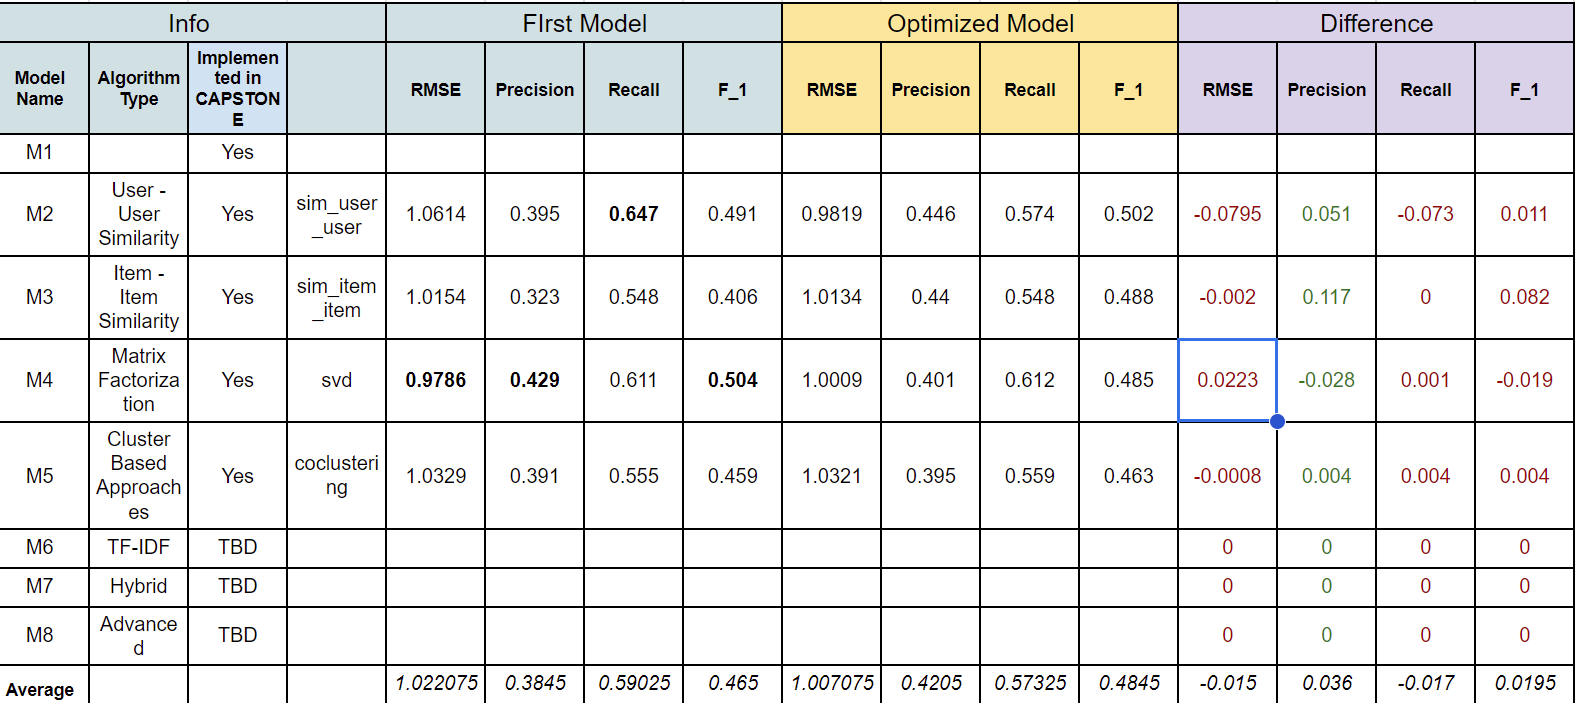**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

*   The overall evaluation metrics performed very low and need to be improved.

*   On average the original models metrics were:

```
AVG: RMSE: 1.022075, Precision 0.3845, Recall: 0.59025, F_1: 0.465
```

*   Most of the hyperparameter tuning imporved the Precision at the cost of Recall (thus also lowering F_1) although most of the RMSE was lowered by -0.015 on AVG.

*   The best performing model was M4 or Matrix Factorization. M4 had the lowest
RMSE and highest Precision and F1, Recall was very close to M2. M2 had the highest Recall metric. The recommendation values however were much lower AVG(-0.7) than compared to the other models.

```
*  M1 - Popularity
Good base model and easy to implement

*  M2 - User - User CF
Showed the highest Recall value and second best performing model
sim_user_user,1.0614,0.395,0.647,0.491,0.9819,0.446,0.574,0.502,-0.0795,0.051,-0.073,0.011

Top 5 recommendations
[(9942, 2.7),
(8324, 2.5),
(614, 2.5),
(657, 2.4),
(6450, 2.3)]

*  M3 - Item - Item CF
Showed the highest improvement in precision (+0.02) after parameter tuning
sim_item_item,1.0154,0.323,0.548,0.406,1.0134,0.44,0.548,0.488,-0.002,0.117,0,0.082

Top 5 recommendations
[(8324, 2.8),
(9942, 2.6),
(4811, 2.5),
(614, 2.5),
(4954, 2.4)]

*  M4 - **Matrix Factorization CF**
Best performing model overall
svd,0.9786,0.429,0.611,0.504,1.0009,0.401,0.612,0.485,0.0223,-0.028,0.001,-0.019

Top 5 recommendations
[(6450, 2.0),
(2220, 1.9),
(9942, 1.9),
(5653, 1.8),
(8324, 1.8)]

*  M5 - Cluster Based Approach
coclustering,1.0329,0.391,0.555,0.459,1.0321,0.395,0.559,0.463,-0.0008,0.004,0.004,0.004

Top 5 recommendations
[(6450, 2.2),
(8324, 2.2),
(2220, 2.1),
(5531, 2.0),
(352, 1.9)]

*  M6 - TF-IDF

```


**2. Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?



**3. Proposal for the final solution design:**
- What model do you propose to be adopted? Why is this the best solution to adopt?

Proposal:
*   Adopt model M4 Matrix Factorization
*   Improve the Data Preparation and tryout different filters e.g.,
    *   USER CUTOFF and other selection criteria (song, user cutoffs)
    *   Apply the IQR Qunatile analysis performed
    *   Experiment with the Spotify Web API for data augmentation adding more features e..g, song genre
*   Tryout other models:
    *   Hybrid models: Combining M4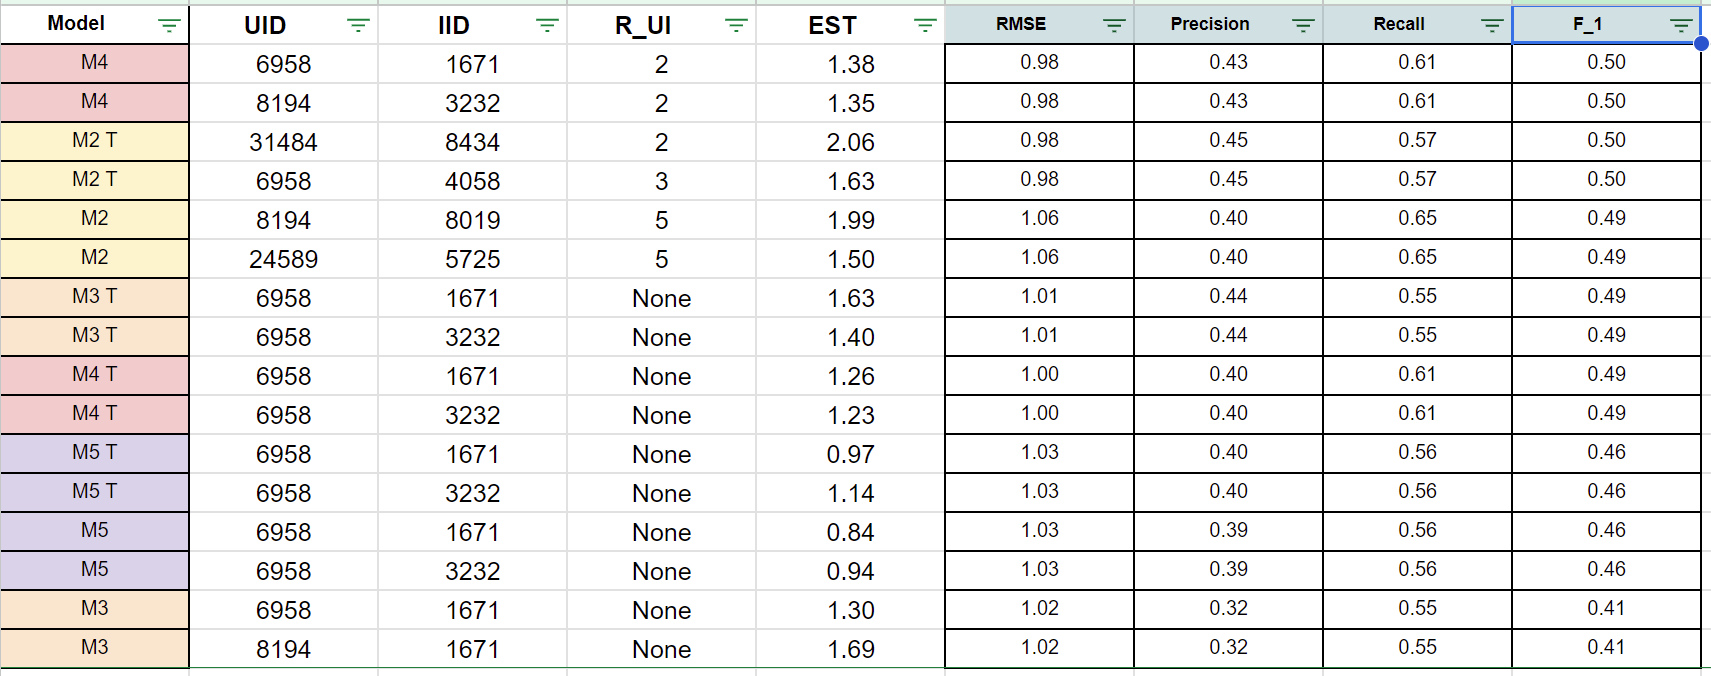 and M2 to improve performance
    *   




### Convert to HTML

In [ ]:
# !pip install nbconvert
# !pip install --upgrade nbconvert
# import nbconvert
# Mounting the drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# !jupyter nbconvert --to html /content/sample_data/CAPSTONE_music_recsys_gabrysiak.ipynb

## Conclusions & Recommendations


### Executive summary
**What are the most important findings from the analysis done in Milestone**
1.   Further details can be found in the pandas report. The initial dataset had a total of 154377 x 7 variables. Play count information included outluiers that were excluded defining the final dataset with song of playcounts of =< 5.Furthermore the most popular bands were Coldplay and most popular songs were Use Somebody, Yellow and Don't Stop the Music.

**Provide the final proposed model specifications**
2. Most models had an initial poor performance and poor improvment upon hyperparameter tuning. The model with best performance was M4 or Matrix Factorization. The same model had very poor improvement upon hyperparameter tuning or data augmentation with Spotipy. The optimized model paramteres are the following: {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}. The models were tested with different data preparation operations and parameter configurations however this one was the best performing one.




### Problem and solution summary
**Summary of the problem**

1.   The goal of this project is to come up with the ‘optimal’ design of a recommendation system. ‘Optimal’ is very subjective and it refers hereby to not only evaluation metrics but other aspects that can be described with the following steps: Understanding the data with user preferences Understanding what an ‘optimal’ recommendation system is and its trade-offs (evaluation metrics, business context, user preferences, scalability/efficiency) or limitations (cold-start problem) Performing several model design experiments and testing (+ trade-offs/drawbacks as above) Selecting the final model and getting user feedback



**Explain the reason for the proposed solution design**
1.   The proposed solution design likely stems from the specific requirements and challenges of the project, particularly in the context of building a recommendation system using the Spotify Web API and other relevant data. While the exact details of the project and its objectives aren't provided, I can outline general reasons why certain components or approaches might be part of the proposed solution design: The decision to augment the initial dataset with the Spotify Web API likely came from the need to enrich the dataset with additional relevant information.The choice of variables included in the augmented dataset is likely driven by factors such as their relevance to music recommendation and their availability from the Spotify Web API.The selection of M4 as the best model is based on the evaluation metrics and its characteristics. By learning latent factors, the model can generalize well to unseen user-item pairs, making it effective in recommending items that a user has not interacted with.


**How it would affect the problem/business?**
1.   Matrix factorization models are computationally efficient and scalable, making them suitable for large-scale recommendation systems.As datasets grow, the model should scale efficiently to handle the increased volume of user-item interactions. Matrix factorization techniques are well-suited for scalability.Given that the data augmentation created no impact it needs to be revised for model improvement.The data augmentation step took considerable time and resources even after being implemented with Spark.

### Recommendations for implementation

**What are some key recommendations to implement the solutions?**
1.   To successfully implement the recommendation system, it's crucial to evaluate the model's performance using metrics like RMSE, precision, and recall. Integrate a user feedback loop to collect valuable insights and employ A/B testing for continuous optimization. Ensure scalability of the infrastructure to accommodate growing user bases and items. Prioritize low-latency recommendations and strike a balance between personalization and diversity for an engaging user experience. Enhance system transparency by providing explanations for recommendations and incorporate additional metadata to improve quality. Prioritize user privacy and security, update the model regularly for content freshness, and dynamically adjust hyperparameters based on evolving user behavior. Collaborate with stakeholders for alignment with business goals, document system details for knowledge transfer, and implement robust monitoring for proactive maintenance. Perform some user -feedback evaluation e.g., A/B testing and if needed educate users on system interaction, and foster a culture of continuous improvement through iterative development and adaptation to changing user preferences.

**What are the key actionables for stakeholders?**
1.   Regular feedback is essential for evaluating the system's performance metrics, such as RMSE, precision, and recall, ensuring continuous improvement. Collaborating on strategies to enhance the user experience, ensuring scalability, and addressing privacy concerns are key areas where stakeholder input is invaluable. Alignment with broader business goals, transparent communication about the system's workings, and educational initiatives for users contribute to a positive and trusted relationship. Stakeholders should stay agile in adapting the system to changing requirements, participate in strategic planning, and contribute to documentation and knowledge transfer within the organization. Ultimately, their engagement is vital for the recommendation system to thrive and remain aligned with organizational objectives.

**What is the expected benefit and/or costs? What are the key risks and challenges?**
1.   The recommendation system is expected to enhance user experience and engagement, providing personalized content and potentially boosting user loyalty. However, implementing and maintaining the system involves investment in technology and data infrastructure. There's a need for ongoing monitoring to ensure user privacy and data security compliance. The risk of biased recommendations poses a challenge, requiring regular audits and adjustments to algorithms. Success depends on the availability and quality of data, and any issues in data collection may impact accuracy. Transparent communication with users about recommendation generation is crucial, and finding the right balance between personalization and 'serendipity' is an ongoing challenge. In conclusion, while the system offers significant benefits, managing costs, risks, and challenges is vital for sustained success.

**What further analysis needs to be done or what other associated problems need to be solved?**
1.   Further analysis should focus on continuous evaluation and refinement of the recommendation system. Ongoing monitoring of user feedback, interaction patterns, and any emerging trends is crucial. Conducting A/B testing to assess the impact of algorithm adjustments on user engagement can provide valuable insights. Addressing issues related to cold starts for new users or items is essential for broadening the system's applicability. Exploring advanced algorithms or hybrid models that combine collaborative and content-based approaches may enhance recommendation accuracy. Additionally, analyzing the system's scalability and performance under increasing user loads is important for ensuring a seamless user experience. Regular updates and adaptation to changing user preferences and industry dynamics will contribute to the system's long-term success.

In [229]:
!python -m pip install -U notebook-as-pdf
#pyppeteer-install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


NameError: ignored